In [52]:
import sys
import os
import numpy as np
import random as rand

# File Generation

In [53]:
def buildNameList(n, length=10):
    names = []
    char = rand.randrange(52)
    if char >= 26:
        char += 6
    prefix = chr(char + 65)
    for i in range(length - 2):
        char = rand.randrange(62)
        if char >= 36:
            char = chr(char - 36 + 97)
        elif char >= 10:
            char = chr(char - 10 + 65)
        else:
            char = chr(char + 48)
        prefix += char
    possibleEnds = set([str(i) for i in range(10)])
    for i in range(65, 91):
        possibleEnds.add(chr(i))
        possibleEnds.add(chr(i | 32))
    for i in range(n):
        char = rand.sample(possibleEnds, 1)[0]
        possibleEnds.remove(char)
        names.append(prefix + char)
    return names

In [54]:
def minimalConstraints(lower, upper):
    set_add = set()
    set_add.add((lower, upper, upper + 1)) #Addition must exist outside of the ordered set
    
    belowAddition = rand.randint(lower+1, upper)
    belowLower = rand.randint(lower, belowAddition - 1)
    set_add.add((belowAddition, upper + 1, belowLower)) #Addition must come at the end of the ordered set, sufficiently random/relaxed
    
    return set_add

def buildMinConstraints(n):
    _n = int(n / 5)
    constraints = set()
    for i in range(5):
        for j in range(_n - 2):
#             print((i*5+1,i*5 + j + 2))
            constraints = constraints.union(minimalConstraints(i*4+1,i*4 + j + 2))
    for m in range(5):
        s = m*_n+1
        e = (m+1)*_n
        for k in range(5):
            if k!=m:
                _s = k*_n+1
                _e = (k+1)*_n
                set_add = set()
        #             print((k, k+_n, i*5+1))
        #             print((k, k+_n, i*5+1+_n))
                set_add.add((_s, _e, s))
                set_add.add((_s, _e, e))
                constraints = constraints.union(set_add)
    return constraints

In [55]:
def blowEveryone(constraints):
    newConstraints = set()
    for i in constraints:
        blowSomeone(constraints, newConstraints, i)
    return newConstraints

def blowSomeone(constraints, newConstraints, i):
    lower = i[0]
    upper = i[1]
    boundRange = upper - lower
    if boundRange > 1:
        randomMid = (0 if boundRange == 2 else rand.randrange(boundRange - 2))  + 1 + lower
        if newConstraints == None:
            constraints.remove(i)
            constraints.add((lower, randomMid, i[2]))
            constraints.add((randomMid, upper, i[2]))
        else:
            newConstraints.add((lower, randomMid, i[2]))
            newConstraints.add((randomMid, upper, i[2]))
    else:
        if newConstraints != None:
            newConstraints.add(i)

In [56]:
def relaxMinConstraints(constraints, relaxFactor = 3):
    newConstraints = set()
    for i in constraints:
        if rand.randrange(2) == 0:
            #Relax constraint to not be so tight
            lowerRandRange = rand.randrange(max(1, i[0] // relaxFactor))
            upperRandRange = rand.randrange(max(1, (i[2] - i[1]) // relaxFactor))
            newConstraints.add((i[0] - lowerRandRange, i[1] + upperRandRange, i[2]))
        else:
            newConstraints.add(i)
    return newConstraints

In [57]:
def orderedPrint(s):
    for i in range(20):
        for j in s:
            if j[0]==i+1:
                print(j)

In [58]:
def expandConstraints(wizards, consLimit, tryLimit):
    constraints = buildMinConstraints(wizards)
    size = len(constraints)
#     orderedPrint(constraints)
#     print(size)
    while 2 * size < consLimit:
        constraints = blowEveryone(constraints)
        if size == len(constraints): 
            break
        else:
            size = len(constraints)
    #Fill in the blown up constraints, up to consLimit
    while len(constraints) < consLimit and tryLimit > 0:
        #Rate limit the number of tries 
        tryLimit -= 1
        i = rand.sample(constraints, 1)[0]
        blowSomeone(constraints, None, i)
            
    #Relax the well ordered minimal constraints a little
    constraints = relaxMinConstraints(constraints, relaxFactor=4) #relaxFactor is a dividing factor of the relaxation range, smaller numbers give more relaxation/randomization but also provide stronger constraints
    #Fill in the constraint limit with redundant/garbage constraints, up to 500
    
    return constraints

In [59]:
def randOrder(bound1, bound2, var):
    if rand.randrange(2) == 0:
        return (bound1, bound2, var)
    else:
        return (bound2, bound1, var)
    
def generateNoise(numWizards, n, realCons):
    constraints = []
    i=0
    while i < n:
        wiz = rand.randint(1, numWizards-1)
        other = rand.randint(1, numWizards)
        while other == wiz or other == wiz+1 or other == wiz-1:
            other = rand.randint(1, numWizards)
        con = (wiz, wiz+1, other)
        if con not in constraints or con not in realCons:
            constraints.append(con)
            i+=1
    return constraints

# File Import/Export

In [60]:
def displayConstraints(constraints):
    print("Constraints:")
    for i in constraints:
        print(" ", i)

def exportConstraints(n, constraints, nameReplace=True, randomizeOrder=True):
    constraints = list(constraints)
    rand.shuffle(constraints)
    string = str(n) + "\n"
    # Handle name replacement here
    nameList = buildNameList(n)
    # Generate list of loooooong random names, use numbers as indices of this list
    for i in range(n):
        string += (str(i + 1) if not nameReplace else nameList[i]) + (" " if i < n -1 else "")
    string += "\n"
    string += str(len(constraints)) + "\n"
    for i in constraints:
        if randomizeOrder:
            i = randOrder(*i)
        if nameReplace:
            string += nameList[i[0] - 1] + " " + nameList[i[1] - 1] + " " + nameList[i[2] - 1] + "\n"
        else:
            string += str(i[0]) + " " + str(i[1]) + " " + str(i[2]) + "\n"
        
    #print(string)
    f = open("input" + str(n) + ".in", "w")
    f.write(string)
    f.close()

In [82]:
def readInput(filename):
    with open(filename) as f:
        numWizards = int(f.readline())
#         trueOrder = f.readline().split(" ")
        numConstraints = int(f.readline())
        constraints = []
        wizards = set()
        for _ in range(numConstraints):
            c = f.readline().split()
            constraints.append(c)
            for w in c:
                wizards.add(w)

    wizards = list(wizards)  
    dictWizards = {}
    for i in range(len(wizards)):
        dictWizards[wizards[i]] = str(i + 1)
    newConstraints = []
    for i in constraints:
        for j in range(3):
            i[j] = dictWizards[i[j]]
        if int(i[0]) > int(i[1]):
            i[0], i[1] = i[1], i[0]
    return numWizards, numConstraints, [str(i + 1) for i in range(numWizards)], constraints

def displayInput(filename):
    n, c, names, constraints = readInput(filename)
    string = str(n) + "\n"
    string += " ".join(names) + "\n"
    string += str(c) + "\n"
    for i in constraints:
        string += " ".join(i) + "\n"
    print(string)

## input20.in

In [81]:
n = 20
minimalConstraintLimit = n*10
hardLimitToReachMinimal = n*5
con = expandConstraints(n, minimalConstraintLimit, hardLimitToReachMinimal)
noise = relaxMinConstraints(generateNoise(n, 201 - len(con), con))
res = list(con) + list(noise)
# res = list(con)
exportConstraints(n, res, nameReplace=True, randomizeOrder=True)

## input35.in

## input50.in

# Statistics 

In [ ]:
stats = np.zeros(20*20+1)
for i in res:
    stats[i[0]*20+i[1]] += 1

In [ ]:
import matplotlib.pyplot as plt
plt.plot(stats[stats!=0])
plt.show()
len(stats[stats!=0])

In [ ]:
highPairs = [i for i, x in enumerate(stats>5) if x]
for i in highPairs:
    print((i//20,i%20))

In [ ]:
for asd in range(0,0):
    print('hi')

In [ ]:
range()

In [83]:
a,b,c,d = readInput('input20_0.in')

In [84]:
a

20

In [85]:
b

500

In [86]:
c

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20']

In [87]:
d

[['3', '10', '17'],
 ['1', '2', '19'],
 ['3', '4', '17'],
 ['10', '13', '5'],
 ['1', '2', '20'],
 ['3', '17', '2'],
 ['6', '11', '12'],
 ['7', '12', '17'],
 ['2', '17', '7'],
 ['8', '13', '20'],
 ['5', '11', '10'],
 ['1', '3', '19'],
 ['3', '17', '1'],
 ['3', '17', '11'],
 ['4', '5', '12'],
 ['5', '9', '18'],
 ['3', '17', '2'],
 ['19', '20', '14'],
 ['10', '15', '16'],
 ['1', '19', '14'],
 ['11', '12', '5'],
 ['8', '20', '19'],
 ['7', '13', '3'],
 ['10', '14', '11'],
 ['3', '17', '1'],
 ['5', '11', '9'],
 ['5', '11', '9'],
 ['2', '17', '12'],
 ['5', '11', '9'],
 ['2', '4', '17'],
 ['7', '20', '10'],
 ['2', '8', '19'],
 ['13', '16', '7'],
 ['1', '18', '17'],
 ['14', '18', '9'],
 ['8', '10', '11'],
 ['2', '3', '20'],
 ['5', '13', '1'],
 ['5', '14', '3'],
 ['3', '17', '20'],
 ['5', '11', '10'],
 ['5', '9', '7'],
 ['8', '15', '20'],
 ['5', '9', '16'],
 ['7', '19', '11'],
 ['5', '11', '10'],
 ['8', '11', '17'],
 ['15', '18', '12'],
 ['5', '10', '7'],
 ['2', '17', '8'],
 ['1', '17', '19'],
 

In [91]:
stats = np.zeros(20*20+1)
for i in d:
    stats[int(i[0])*20+int(i[1])] += 1

In [97]:
highPairs = [i for i, x in enumerate(stats>10) if x]
for i in highPairs:
    print((i//20,i%20))

(1, 3)
(1, 17)
(3, 17)
(5, 11)


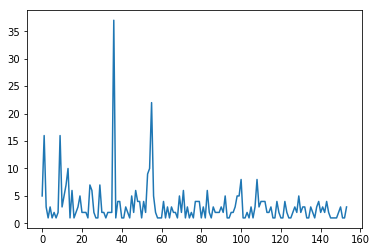

154

In [95]:
import matplotlib.pyplot as plt
plt.plot(stats[stats!=0])
plt.show()
len(stats[stats!=0])